In [47]:
import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import PIL.Image as Image

### load the npz file and create the array to be then used for model training and testing

In [48]:
with np.load('images_data.npz', allow_pickle=True) as npz_file:
    df = pd.DataFrame(npz_file['values'], columns= npz_file['columns'])
    
df_train = df[df['imageSet'] == 'train']
X_tr = df_train.drop(['imageSet','category','imageFileName'], axis=1).values
X_tr = np.float32(X_tr)
y_tr = df_train.category.values

df_test = df[df['imageSet'] == 'test']
X_te = df_test.drop(['imageSet','category','imageFileName'], axis=1).values
X_te = np.float32(X_te)
y_te = df_test.category.values

### let's create a simpte tree with of depth 3
- first use all high-level features from Mobilnet

In [49]:
from sklearn.tree import DecisionTreeClassifier

dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
dt.fit(X_tr, y_tr)
dt.score(X_te, y_te)

0.68

- the accuracy using all high level features is of 68% with the test dataset
- compared to k-NN the accuracy obtained is quite low.
- building a decision tree from 1280 features to be then reduced to 6 classes can be not suitable for decision trees.

### let's vizualise the tree 

In [50]:
from sklearn.tree import export_graphviz

features_names=df_train.drop(['imageSet','category','imageFileName'], axis=1).columns
categories = ['bike', 'car', 'motorcycle','other','truck','van']

# Export decision tree
dot_data = export_graphviz(
    dt, out_file=None,
    feature_names=features_names, class_names=categories,
    filled=True, rounded=True, proportion=True   
)

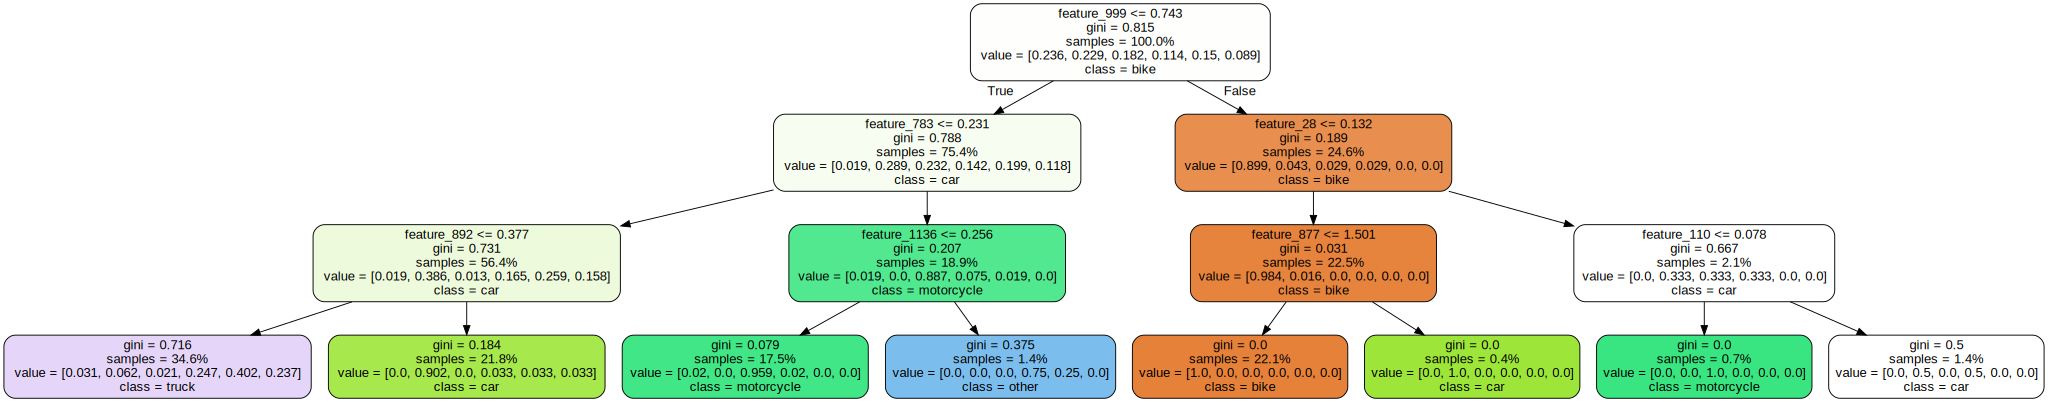

In [51]:
import graphviz

# Display decision tree
graphviz.Source(dot_data)

### let see if we can achieve a better result reducing the dimensions
- first use the PCA to reduce the amount of featuers from 1280 to 280
- I first decided to rescale the data before applying PCA but removed it as it seems that the tree building processs gives better resulst without rescaling

In [61]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_tr_rescaled = scaler.fit_transform(X_tr)
X_te_rescaled = scaler.transform(X_te)

pca = PCA(n_components=None)
#pca.fit(X_tr_rescaled, y_tr)
#X_tr_pca = pca.transform(X_tr_rescaled)
#X_te_pca = pca.transform(X_te_rescaled)
pca.fit(X_tr, y_tr)
X_tr_pca = pca.transform(X_tr)
X_te_pca = pca.transform(X_te)
X_te_pca.shape

(50, 280)

In [62]:
dt = DecisionTreeClassifier(criterion='gini', max_depth=3, random_state=0)
dt.fit(X_tr_pca, y_tr)
dt.score(X_te_pca, y_te)

0.82

- with a feature reductions from 1280 to 280 using PCA I get an accuracy of 82% which is now better but still below k-NN
- using only the 2 main components, I get an accuracy of 84%

### let's perform a gridsearch to visualize optimum parameters of the decision tree:
- optimize depth of the tree
- optimize components of PCA

In [63]:
gs_results = []
for n in range(1,100,1):
    pca = PCA(n_components=n)
    pca.fit(X_tr, y_tr)
    X_tr_pca = pca.transform(X_tr)
    X_te_pca = pca.transform(X_te)
    
    for d in range(1,10,1):
        dt = DecisionTreeClassifier(criterion='gini', max_depth=d, random_state=0)
        dt.fit(X_tr_pca, y_tr)      
        
        gs_results.append({
            'n': n,
            'd': d,
            'train_accuracy': dt.score(X_tr_pca, y_tr),
            'test_accuracy': dt.score(X_te_pca, y_te)
    })

# Convert results to DataFrame
gs_results = pd.DataFrame(gs_results)
gs_results.sort_values(by='test_accuracy', ascending=False).head()
    

,d,n,test_accuracy,train_accuracy
435,4,49,0.92,0.953571
86,6,10,0.92,0.982143
67,5,8,0.92,0.967857
346,5,39,0.92,0.978571
102,4,12,0.92,0.953571


- Best accuracy of 92% with n=49 and depth = 4 